In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns

In [2]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

In [6]:
df = df[df['RevLineCr'].isin(['Y', 'N'])]
df.nunique()

LoanNr_ChkDgt        621685
Name                 558533
City                  28652
State                    52
Zip                   30286
Bank                   5479
BankState                55
NAICS                  1306
ApprovalDate           9819
ApprovalFY               51
Term                    406
NoEmp                   533
NewExist                  3
CreateJob               224
RetainedJob             316
FranchiseCode          2259
UrbanRural                3
RevLineCr                 2
LowDoc                    2
ChgOffDate             6288
DisbursementDate       8242
DisbursementGross    107798
BalanceGross              8
MIS_Status                2
ChgOffPrinGr          61542
GrAppv                17385
SBA_Appv              31478
cat_activites            25
SBA_loan_float        31478
bank_loan_float       17385
crisis                    2
dtype: int64

In [27]:
features_of_interest = [
    'DisbursementGross','Term','bank_loan_float','SBA_loan_float',
    'State','cat_activites','UrbanRural','LowDoc','MIS_Status','FranchiseCode',
    'RevLineCr',
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term',
                    'DisbursementGross',
    
]


ordinal_column = [
    'LowDoc','UrbanRural'
]

categorical_column = [
    'State','cat_activites','FranchiseCode','MIS_Status',
]


target_name = "RevLineCr"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('RevLineCr', axis=1)
X_test = X_test.drop('RevLineCr', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [29]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [30]:
clf = make_pipeline(preprocessor,lgb.LGBMClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
clf.fit(X_train, y_train_encoded)

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 181307, number of negative: 378209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 559516, number of used features: 332
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324043 -> initscore=-0.735255
[LightGBM] [Info] Start training from score -0.735255


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode',
                                                   'MIS_Status']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc', 'UrbanRural']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float', 'Term',
                                                   'DisbursementGross'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [31]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', clf.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC-ROC score: 0.9874707882827379
accuracy 0.9457285785520114
rappel 0.9580313220371206
f1_score 0.9598333333333333
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     42079
           1       0.91      0.92      0.92     20090

    accuracy                           0.95     62169
   macro avg       0.94      0.94      0.94     62169
weighted avg       0.95      0.95      0.95     62169



In [33]:
#Dataframe pour les features of importances

df_rf = pd.DataFrame(clf[-1].feature_importances_,clf[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__FranchiseCode_91999', 'categorical__FranchiseCode_92000',
       'categorical__MIS_Status_CHGOFF', 'categorical__MIS_Status_P I F',
       'ordinal__LowDoc', 'ordinal__UrbanRural', 'numeric__bank_loan_float',
       'numeric__SBA_loan_float', 'numeric__Term',
       'numeric__DisbursementGross'],
      dtype='object', length=2256)

In [34]:
# Création des sommes pour les features importances pour chaque variables


liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)

['sum_DisbursementGross', 'sum_Term', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_MIS_Status', 'sum_FranchiseCode', 'sum_RevLineCr']


In [35]:
df_rf_graphique = df_rf[liste_sum]

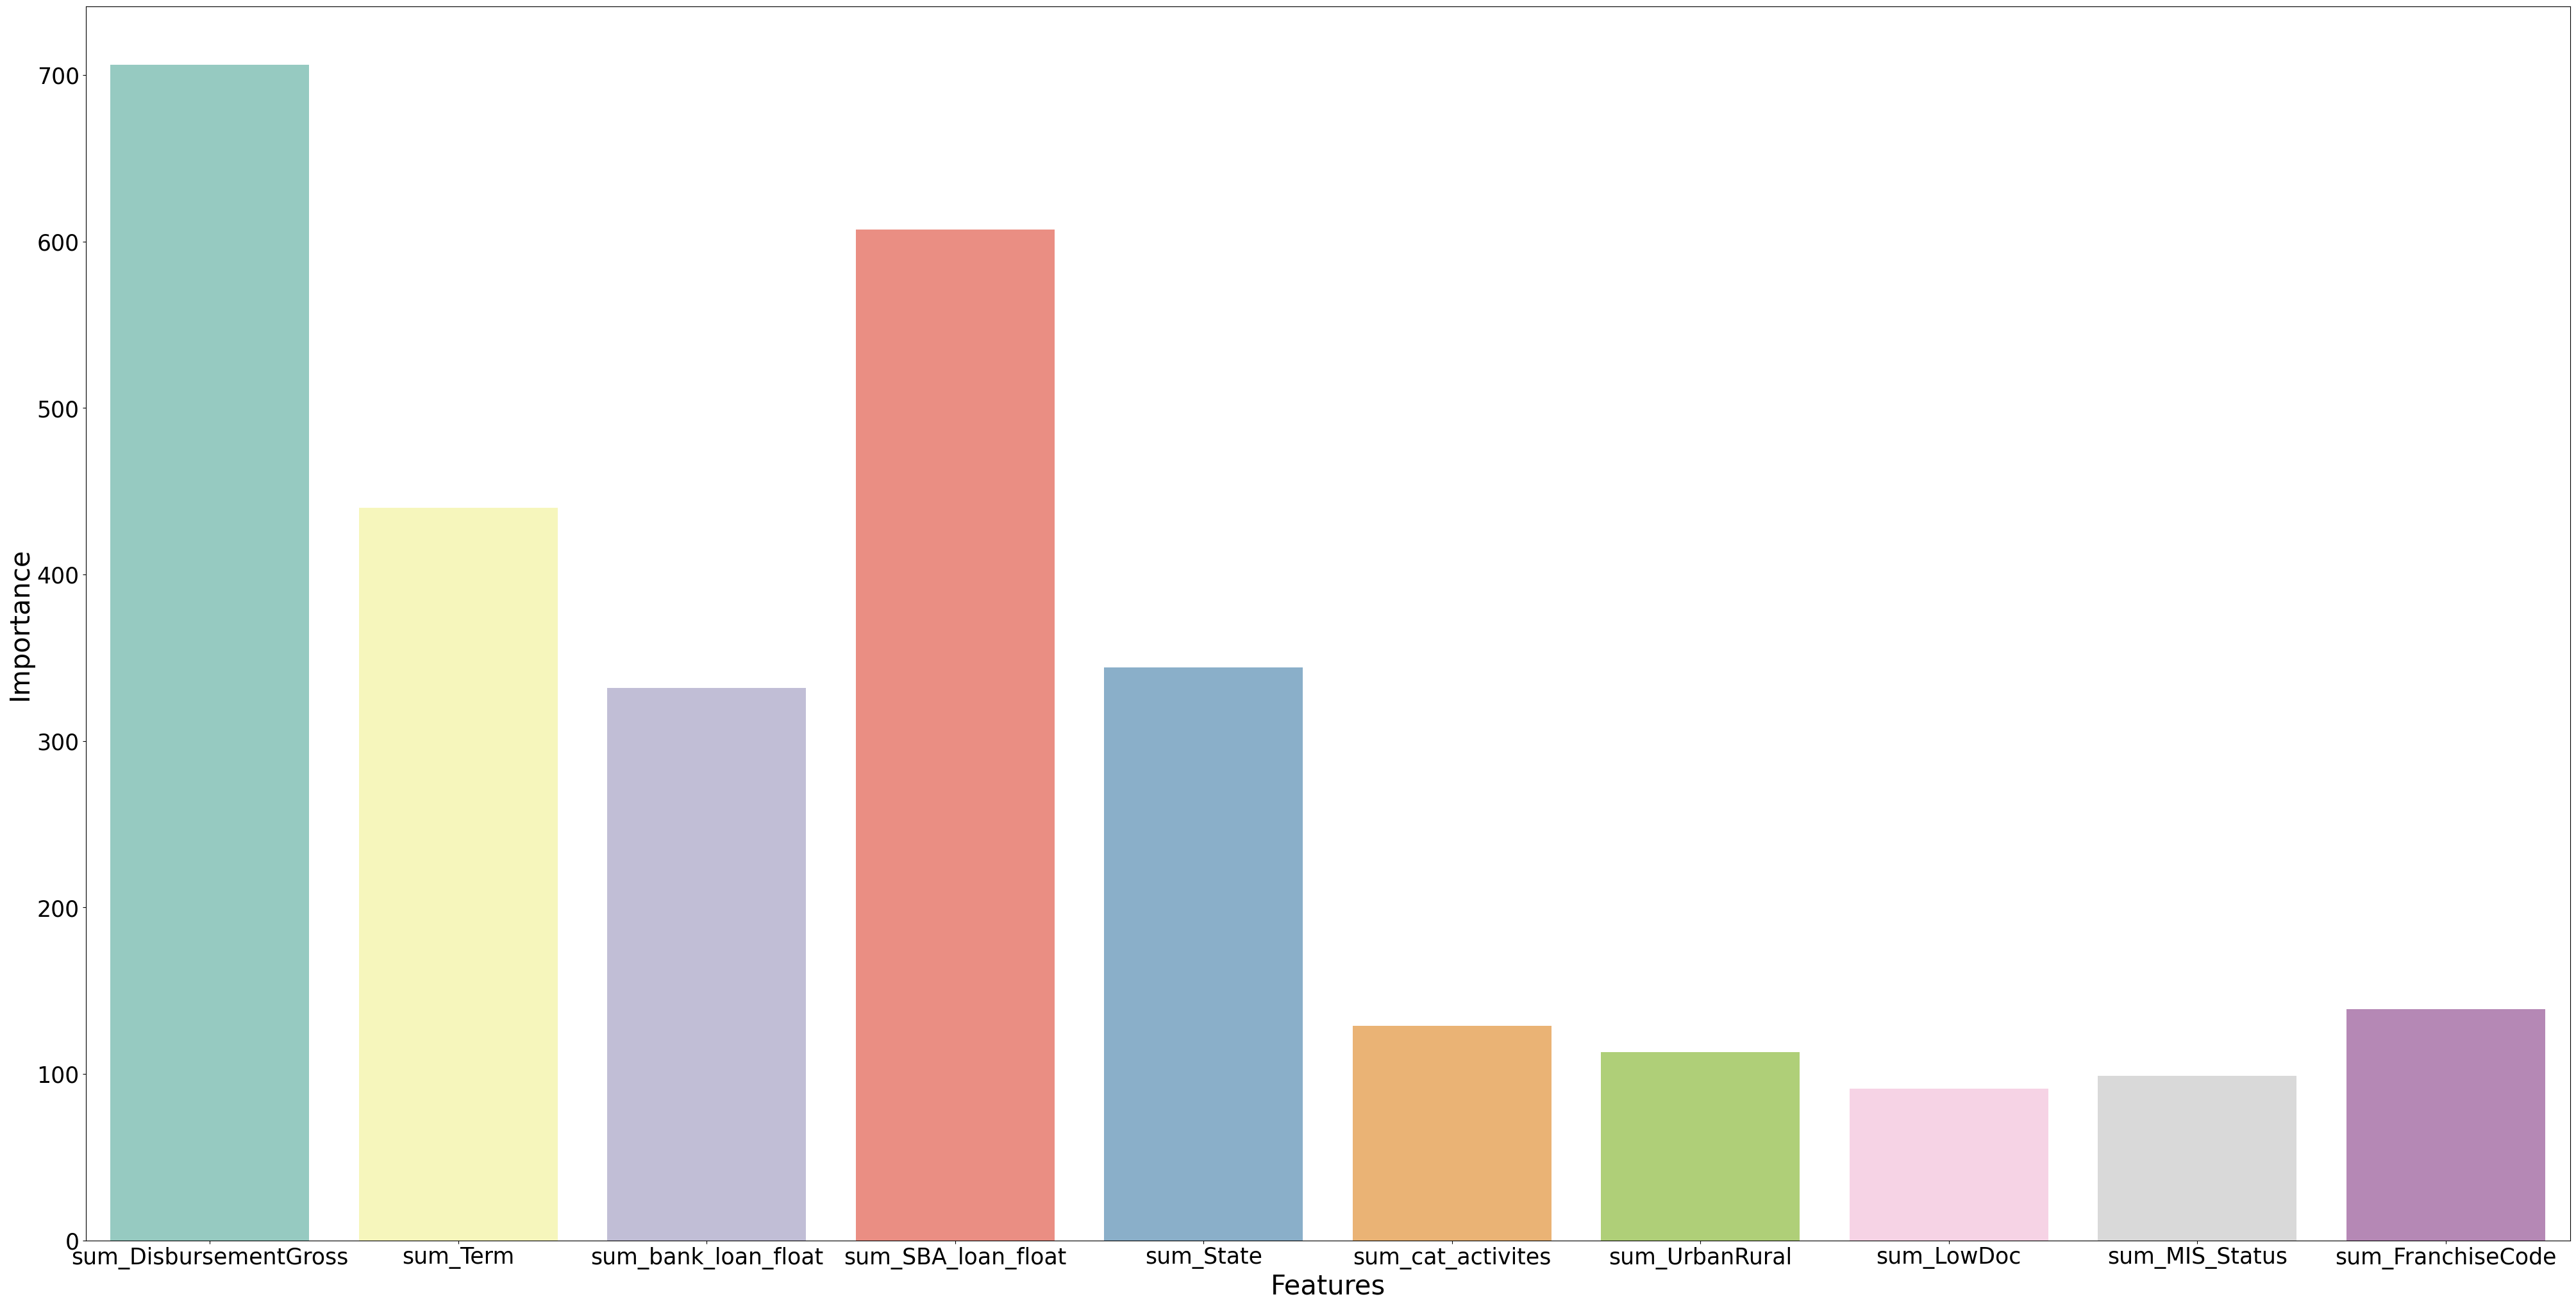

In [36]:


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_RevLineCr', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [32]:
import pickle
pickle.dump(clf,open('RevLineCr_lgb.pkl','wb'))